## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

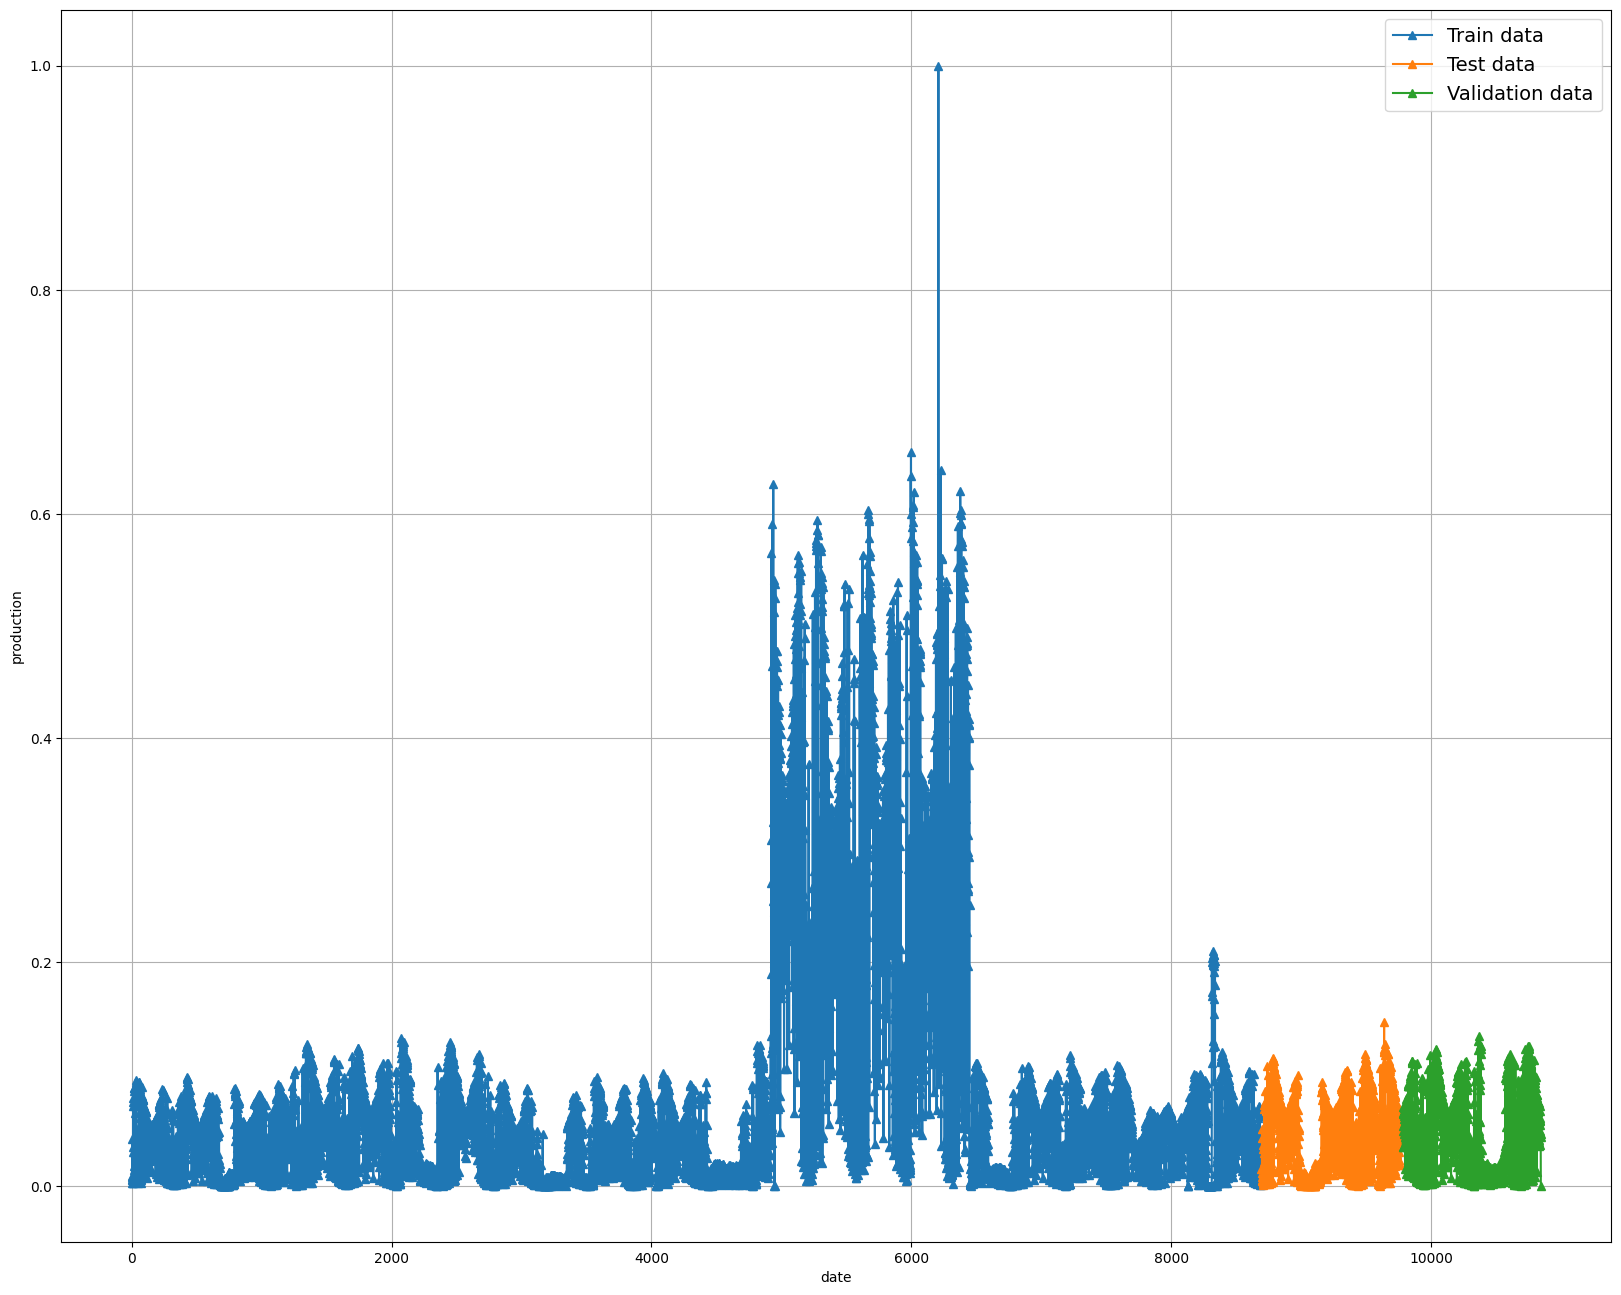

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 128
kernel_size = 1
activation = 'tanh'
dense_units = 128
learning_rate = 0.006066565714829281

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()

C:\Users\peesc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 128)          │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,193 (907.00 KB)

 Trainable params: 232,193 (907.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:05:57] [setup] RAM Tracking...
[codecarbon INFO @ 03:05:57] [setup] CPU Tracking...
[codecarbon WARNING @ 03:05:57] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 03:05:59] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
[codecarbon INFO @ 03:05:59] [setup] GPU Tracking...
[codecarbon INFO @ 03:05:59] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:05:59] >>> Tracker's metadata:
[codecarbon INFO @ 03:05:59]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 03:05:59]   Python version: 3.12.3
[codecarbon INFO @ 03:05:59]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:05:59]   Available RAM : 31.935 GB
[codecarbon INFO @ 03:05:59]   CPU count: 8
[codecarbon INFO @ 03:05:59]   CPU model: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
[codecarbon INFO @ 03:05:59]   GPU count: 1
[codecarbon INFO @ 03:05:59]   GPU mo

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [ ]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 0.4913 - val_loss: 0.0536
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0631 - val_loss: 0.0298
Epoch 3/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0435

[codecarbon INFO @ 03:06:12] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:06:12] Energy consumed for all CPUs : 0.000133 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:06:12] Energy consumed for all GPUs : 0.000107 kWh. Total GPU Power : 38.18362315635641 W
[codecarbon INFO @ 03:06:12] 0.000272 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0435 - val_loss: 0.0293
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0410 - val_loss: 0.0277
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.0395 - val_loss: 0.0286
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0393 - val_loss: 0.0280
Epoch 7/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0371

[codecarbon INFO @ 03:06:22] Energy consumed for RAM : 0.000067 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:06:22] Energy consumed for all CPUs : 0.000265 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:06:22] Energy consumed for all GPUs : 0.000191 kWh. Total GPU Power : 30.447952430791553 W
[codecarbon INFO @ 03:06:22] 0.000522 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0387 - val_loss: 0.0267
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0380 - val_loss: 0.0270
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0377 - val_loss: 0.0261
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0371 - val_loss: 0.0305
Epoch 11/300
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0378

[codecarbon INFO @ 03:06:32] Energy consumed for RAM : 0.000100 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:06:32] Energy consumed for all CPUs : 0.000397 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:06:32] Energy consumed for all GPUs : 0.000250 kWh. Total GPU Power : 21.10633274648923 W
[codecarbon INFO @ 03:06:32] 0.000747 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0379 - val_loss: 0.0258
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0366 - val_loss: 0.0323
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0387 - val_loss: 0.0299
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0371 - val_loss: 0.0271
Epoch 15/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0361

[codecarbon INFO @ 03:06:42] Energy consumed for RAM : 0.000133 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:06:42] Energy consumed for all CPUs : 0.000530 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:06:42] Energy consumed for all GPUs : 0.000322 kWh. Total GPU Power : 25.836172673913634 W
[codecarbon INFO @ 03:06:42] 0.000985 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0361 - val_loss: 0.0276
Epoch 16/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0360 - val_loss: 0.0303
Epoch 17/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0379 - val_loss: 0.0243
Epoch 18/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0358 - val_loss: 0.0244
Epoch 19/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0351

[codecarbon INFO @ 03:06:52] Energy consumed for RAM : 0.000167 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:06:52] Energy consumed for all CPUs : 0.000661 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:06:52] Energy consumed for all GPUs : 0.000421 kWh. Total GPU Power : 35.674480223052214 W
[codecarbon INFO @ 03:06:52] 0.001249 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0351 - val_loss: 0.0233
Epoch 20/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0350 - val_loss: 0.0244
Epoch 21/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0345 - val_loss: 0.0254
Epoch 22/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0356 - val_loss: 0.0248
Epoch 23/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0342 - val_loss: 0.0242
Epoch 24/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0346

[codecarbon INFO @ 03:07:02] Energy consumed for RAM : 0.000200 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:07:02] Energy consumed for all CPUs : 0.000794 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:07:02] Energy consumed for all GPUs : 0.000496 kWh. Total GPU Power : 26.942956348564227 W
[codecarbon INFO @ 03:07:02] 0.001490 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0349 - val_loss: 0.0237
Epoch 25/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0334 - val_loss: 0.0246
Epoch 26/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0348 - val_loss: 0.0238
Epoch 27/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0338 - val_loss: 0.0244
Epoch 28/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0334

[codecarbon INFO @ 03:07:12] Energy consumed for RAM : 0.000233 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:07:12] Energy consumed for all CPUs : 0.000926 kWh. Total CPU Power : 47.5 W


10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0334

[codecarbon INFO @ 03:07:12] Energy consumed for all GPUs : 0.000590 kWh. Total GPU Power : 33.57364461829147 W
[codecarbon INFO @ 03:07:12] 0.001749 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0334 - val_loss: 0.0222
Epoch 29/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0329 - val_loss: 0.0262
Epoch 30/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0335 - val_loss: 0.0272
Epoch 31/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0357 - val_loss: 0.0224
Epoch 32/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0332

[codecarbon INFO @ 03:07:22] Energy consumed for RAM : 0.000266 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:07:22] Energy consumed for all CPUs : 0.001058 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:07:22] Energy consumed for all GPUs : 0.000675 kWh. Total GPU Power : 30.647749147071483 W
[codecarbon INFO @ 03:07:22] 0.001999 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0332

[codecarbon INFO @ 03:07:23] 0.000623 g.CO2eq/s mean an estimation of 19.649376764485037 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0332 - val_loss: 0.0219
Epoch 33/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0322 - val_loss: 0.0302
Epoch 34/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0363 - val_loss: 0.0244
Epoch 35/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0336 - val_loss: 0.0232
Epoch 36/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0321 - val_loss: 0.0209
Epoch 37/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0318

[codecarbon INFO @ 03:07:32] Energy consumed for RAM : 0.000300 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:07:32] Energy consumed for all CPUs : 0.001190 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:07:32] Energy consumed for all GPUs : 0.000730 kWh. Total GPU Power : 19.840001281537525 W
[codecarbon INFO @ 03:07:32] 0.002220 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0323 - val_loss: 0.0218
Epoch 38/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0320 - val_loss: 0.0223
Epoch 39/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0312 - val_loss: 0.0202
Epoch 40/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0319 - val_loss: 0.0211
Epoch 41/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0318 - val_loss: 0.0204
Epoch 42/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0304

[codecarbon INFO @ 03:07:42] Energy consumed for RAM : 0.000333 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:07:42] Energy consumed for all CPUs : 0.001322 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:07:42] Energy consumed for all GPUs : 0.000786 kWh. Total GPU Power : 19.95584635903134 W
[codecarbon INFO @ 03:07:42] 0.002440 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0308 - val_loss: 0.0196
Epoch 43/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0305 - val_loss: 0.0194
Epoch 44/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0312 - val_loss: 0.0231
Epoch 45/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0315 - val_loss: 0.0204
Epoch 46/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0305

[codecarbon INFO @ 03:07:52] Energy consumed for RAM : 0.000366 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:07:52] Energy consumed for all CPUs : 0.001454 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:07:52] Energy consumed for all GPUs : 0.000841 kWh. Total GPU Power : 19.795938152219637 W
[codecarbon INFO @ 03:07:52] 0.002660 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0310 - val_loss: 0.0203
Epoch 47/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0317 - val_loss: 0.0208
Epoch 48/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0313 - val_loss: 0.0194
Epoch 49/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0300 - val_loss: 0.0187
Epoch 50/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0300 - val_loss: 0.0180
Epoch 51/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0294

[codecarbon INFO @ 03:08:02] Energy consumed for RAM : 0.000399 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:08:02] Energy consumed for all CPUs : 0.001586 kWh. Total CPU Power : 47.5 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0296

[codecarbon INFO @ 03:08:02] Energy consumed for all GPUs : 0.000895 kWh. Total GPU Power : 19.558021512563876 W
[codecarbon INFO @ 03:08:02] 0.002880 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0306 - val_loss: 0.0199
Epoch 52/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0310 - val_loss: 0.0196
Epoch 53/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0297 - val_loss: 0.0197
Epoch 54/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0305 - val_loss: 0.0190
Epoch 55/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0291

[codecarbon INFO @ 03:08:12] Energy consumed for RAM : 0.000433 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:08:12] Energy consumed for all CPUs : 0.001718 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:08:12] Energy consumed for all GPUs : 0.000973 kWh. Total GPU Power : 28.262285322421963 W
[codecarbon INFO @ 03:08:12] 0.003124 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0291 - val_loss: 0.0188
Epoch 56/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0293 - val_loss: 0.0182
Epoch 57/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0297 - val_loss: 0.0189
Epoch 58/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0290 - val_loss: 0.0179
Epoch 59/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0289 - val_loss: 0.0191
Epoch 60/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0290

[codecarbon INFO @ 03:08:22] Energy consumed for RAM : 0.000466 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:08:22] Energy consumed for all CPUs : 0.001850 kWh. Total CPU Power : 47.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0291

[codecarbon INFO @ 03:08:22] Energy consumed for all GPUs : 0.001064 kWh. Total GPU Power : 32.48105351380247 W
[codecarbon INFO @ 03:08:22] 0.003379 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0291 - val_loss: 0.0180
Epoch 61/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0289 - val_loss: 0.0180
Epoch 62/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0297 - val_loss: 0.0176
Epoch 63/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0284 - val_loss: 0.0191
Epoch 64/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0284

[codecarbon INFO @ 03:08:32] Energy consumed for RAM : 0.000499 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:08:32] Energy consumed for all CPUs : 0.001982 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:08:32] Energy consumed for all GPUs : 0.001147 kWh. Total GPU Power : 30.057245245455203 W
[codecarbon INFO @ 03:08:32] 0.003628 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0284 - val_loss: 0.0203
Epoch 65/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0291 - val_loss: 0.0206
Epoch 66/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0285 - val_loss: 0.0172
Epoch 67/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0277 - val_loss: 0.0175
Epoch 68/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0281 - val_loss: 0.0174
Epoch 69/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0274

[codecarbon INFO @ 03:08:42] Energy consumed for RAM : 0.000532 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:08:42] Energy consumed for all CPUs : 0.002114 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:08:42] Energy consumed for all GPUs : 0.001203 kWh. Total GPU Power : 20.039765856861937 W
[codecarbon INFO @ 03:08:42] 0.003849 kWh of electricity used since the beginning.


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0274

[codecarbon INFO @ 03:08:43] 0.000578 g.CO2eq/s mean an estimation of 18.215379913343337 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0278 - val_loss: 0.0187
Epoch 70/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0287 - val_loss: 0.0175
Epoch 71/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0282 - val_loss: 0.0180
Epoch 72/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0275 - val_loss: 0.0167
Epoch 73/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0276 - val_loss: 0.0176
Epoch 74/300


[codecarbon INFO @ 03:08:52] Energy consumed for RAM : 0.000566 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:08:52] Energy consumed for all CPUs : 0.002246 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:08:52] Energy consumed for all GPUs : 0.001258 kWh. Total GPU Power : 19.690653155368064 W
[codecarbon INFO @ 03:08:52] 0.004069 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0273 - val_loss: 0.0169
Epoch 75/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0273 - val_loss: 0.0171
Epoch 76/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0268 - val_loss: 0.0176
Epoch 77/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0273 - val_loss: 0.0180
Epoch 78/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0274

[codecarbon INFO @ 03:09:02] Energy consumed for RAM : 0.000599 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:09:02] Energy consumed for all CPUs : 0.002378 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:09:02] Energy consumed for all GPUs : 0.001341 kWh. Total GPU Power : 29.93436442295735 W
[codecarbon INFO @ 03:09:02] 0.004318 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.0275 - val_loss: 0.0174
Epoch 79/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0270 - val_loss: 0.0165
Epoch 80/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0262 - val_loss: 0.0162
Epoch 81/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0265 - val_loss: 0.0172
Epoch 82/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0277

[codecarbon INFO @ 03:09:12] Energy consumed for RAM : 0.000632 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:09:13] Energy consumed for all CPUs : 0.002510 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:09:13] Energy consumed for all GPUs : 0.001413 kWh. Total GPU Power : 25.971496509601103 W
[codecarbon INFO @ 03:09:13] 0.004555 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0277 - val_loss: 0.0168
Epoch 83/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0272 - val_loss: 0.0162
Epoch 84/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0261 - val_loss: 0.0170
Epoch 85/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0258 - val_loss: 0.0173
Epoch 86/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0266 - val_loss: 0.0167
Epoch 87/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0262

[codecarbon INFO @ 03:09:23] Energy consumed for RAM : 0.000665 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:09:23] Energy consumed for all CPUs : 0.002642 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:09:23] Energy consumed for all GPUs : 0.001484 kWh. Total GPU Power : 25.536340435375056 W
[codecarbon INFO @ 03:09:23] 0.004791 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0262 - val_loss: 0.0162
Epoch 88/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0254 - val_loss: 0.0161
Epoch 89/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0251 - val_loss: 0.0160
Epoch 90/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0252 - val_loss: 0.0153
Epoch 91/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0251 - val_loss: 0.0159
Epoch 92/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0248

[codecarbon INFO @ 03:09:33] Energy consumed for RAM : 0.000699 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:09:33] Energy consumed for all CPUs : 0.002774 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:09:33] Energy consumed for all GPUs : 0.001539 kWh. Total GPU Power : 19.814785241450718 W
[codecarbon INFO @ 03:09:33] 0.005012 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0246 - val_loss: 0.0156
Epoch 93/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0240 - val_loss: 0.0157
Epoch 94/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0243 - val_loss: 0.0153
Epoch 95/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0242 - val_loss: 0.0154
Epoch 96/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0239 - val_loss: 0.0153
Epoch 97/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0236

[codecarbon INFO @ 03:09:43] Energy consumed for RAM : 0.000732 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:09:43] Energy consumed for all CPUs : 0.002906 kWh. Total CPU Power : 47.5 W


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0234

[codecarbon INFO @ 03:09:43] Energy consumed for all GPUs : 0.001594 kWh. Total GPU Power : 19.654231579288172 W
[codecarbon INFO @ 03:09:43] 0.005232 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0237 - val_loss: 0.0151
Epoch 98/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0234 - val_loss: 0.0151
Epoch 99/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0241 - val_loss: 0.0154
Epoch 100/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0234 - val_loss: 0.0158
Epoch 101/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0233

[codecarbon INFO @ 03:09:53] Energy consumed for RAM : 0.000765 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:09:53] Energy consumed for all CPUs : 0.003038 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:09:53] Energy consumed for all GPUs : 0.001648 kWh. Total GPU Power : 19.50622004518168 W
[codecarbon INFO @ 03:09:53] 0.005452 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0233 - val_loss: 0.0148
Epoch 102/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0231 - val_loss: 0.0149
Epoch 103/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0227 - val_loss: 0.0148
Epoch 104/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0227 - val_loss: 0.0146
Epoch 105/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0225 - val_loss: 0.0138
Epoch 106/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0213

[codecarbon INFO @ 03:10:03] Energy consumed for RAM : 0.000798 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:10:03] Energy consumed for all CPUs : 0.003170 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:10:03] Energy consumed for all GPUs : 0.001703 kWh. Total GPU Power : 19.770382878625966 W
[codecarbon INFO @ 03:10:03] 0.005672 kWh of electricity used since the beginning.


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0214

[codecarbon INFO @ 03:10:03] 0.000569 g.CO2eq/s mean an estimation of 17.93600917216155 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0215 - val_loss: 0.0155
Epoch 107/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0230 - val_loss: 0.0172
Epoch 108/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0228 - val_loss: 0.0147
Epoch 109/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0224 - val_loss: 0.0150
Epoch 110/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0231 - val_loss: 0.0149
Epoch 111/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0224

[codecarbon INFO @ 03:10:13] Energy consumed for RAM : 0.000832 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:10:13] Energy consumed for all CPUs : 0.003302 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:10:13] Energy consumed for all GPUs : 0.001784 kWh. Total GPU Power : 28.927888533092133 W
[codecarbon INFO @ 03:10:13] 0.005917 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0223 - val_loss: 0.0138
Epoch 112/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0215 - val_loss: 0.0142
Epoch 113/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0219 - val_loss: 0.0149
Epoch 114/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0219 - val_loss: 0.0150
Epoch 115/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0216 - val_loss: 0.0136
Epoch 116/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0206

[codecarbon INFO @ 03:10:23] Energy consumed for RAM : 0.000865 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:10:23] Energy consumed for all CPUs : 0.003434 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:10:23] Energy consumed for all GPUs : 0.001856 kWh. Total GPU Power : 26.059228983884182 W
[codecarbon INFO @ 03:10:23] 0.006155 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0205 - val_loss: 0.0140
Epoch 117/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0210 - val_loss: 0.0142
Epoch 118/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0207 - val_loss: 0.0143
Epoch 119/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0202 - val_loss: 0.0135
Epoch 120/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0197

[codecarbon INFO @ 03:10:33] Energy consumed for RAM : 0.000898 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:10:33] Energy consumed for all CPUs : 0.003566 kWh. Total CPU Power : 47.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0197

[codecarbon INFO @ 03:10:33] Energy consumed for all GPUs : 0.001935 kWh. Total GPU Power : 28.526829292060288 W
[codecarbon INFO @ 03:10:33] 0.006400 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0197 - val_loss: 0.0127
Epoch 121/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0199 - val_loss: 0.0139
Epoch 122/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0209 - val_loss: 0.0144
Epoch 123/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0201 - val_loss: 0.0131
Epoch 124/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0200 - val_loss: 0.0126
Epoch 125/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0199

[codecarbon INFO @ 03:10:43] Energy consumed for RAM : 0.000931 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:10:43] Energy consumed for all CPUs : 0.003698 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:10:43] Energy consumed for all GPUs : 0.002020 kWh. Total GPU Power : 30.56503903842626 W
[codecarbon INFO @ 03:10:43] 0.006650 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0192 - val_loss: 0.0126
Epoch 126/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0189 - val_loss: 0.0118
Epoch 127/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0184 - val_loss: 0.0120
Epoch 128/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0190 - val_loss: 0.0134
Epoch 129/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0185

[codecarbon INFO @ 03:10:53] Energy consumed for RAM : 0.000964 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:10:53] Energy consumed for all CPUs : 0.003830 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:10:53] Energy consumed for all GPUs : 0.002115 kWh. Total GPU Power : 34.28845909154573 W
[codecarbon INFO @ 03:10:53] 0.006910 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0186 - val_loss: 0.0122
Epoch 130/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0183 - val_loss: 0.0120
Epoch 131/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0182 - val_loss: 0.0129
Epoch 132/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0178 - val_loss: 0.0109
Epoch 133/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0169 - val_loss: 0.0121
Epoch 134/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0180

[codecarbon INFO @ 03:11:03] Energy consumed for RAM : 0.000998 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:11:03] Energy consumed for all CPUs : 0.003962 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:11:03] Energy consumed for all GPUs : 0.002171 kWh. Total GPU Power : 20.15018157361913 W
[codecarbon INFO @ 03:11:03] 0.007132 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0178 - val_loss: 0.0124
Epoch 135/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0183 - val_loss: 0.0132
Epoch 136/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0183 - val_loss: 0.0116
Epoch 137/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0173 - val_loss: 0.0114
Epoch 138/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0166 - val_loss: 0.0113
Epoch 139/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0158

[codecarbon INFO @ 03:11:13] Energy consumed for RAM : 0.001031 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:11:13] Energy consumed for all CPUs : 0.004095 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:11:13] Energy consumed for all GPUs : 0.002227 kWh. Total GPU Power : 19.865088361018238 W
[codecarbon INFO @ 03:11:13] 0.007352 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0169 - val_loss: 0.0139
Epoch 140/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0185 - val_loss: 0.0130
Epoch 141/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0177 - val_loss: 0.0119
Epoch 142/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0169 - val_loss: 0.0118
Epoch 143/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0164 - val_loss: 0.0105
Epoch 144/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0155

[codecarbon INFO @ 03:11:23] Energy consumed for RAM : 0.001064 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:11:23] Energy consumed for all CPUs : 0.004227 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:11:23] Energy consumed for all GPUs : 0.002299 kWh. Total GPU Power : 25.873411784562606 W
[codecarbon INFO @ 03:11:23] 0.007589 kWh of electricity used since the beginning.


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0156

[codecarbon INFO @ 03:11:23] 0.000599 g.CO2eq/s mean an estimation of 18.87825544531566 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0155 - val_loss: 0.0116
Epoch 145/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0157 - val_loss: 0.0105
Epoch 146/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0151 - val_loss: 0.0110
Epoch 147/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0159 - val_loss: 0.0110
Epoch 148/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0150

[codecarbon INFO @ 03:11:33] Energy consumed for RAM : 0.001097 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:11:33] Energy consumed for all CPUs : 0.004359 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:11:33] Energy consumed for all GPUs : 0.002362 kWh. Total GPU Power : 22.749887492174246 W
[codecarbon INFO @ 03:11:33] 0.007818 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0150 - val_loss: 0.0101
Epoch 149/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0151 - val_loss: 0.0097
Epoch 150/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0156 - val_loss: 0.0096
Epoch 151/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0147 - val_loss: 0.0104
Epoch 152/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0161 - val_loss: 0.0102
Epoch 153/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0166

[codecarbon INFO @ 03:11:43] Energy consumed for RAM : 0.001131 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:11:43] Energy consumed for all CPUs : 0.004491 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:11:43] Energy consumed for all GPUs : 0.002416 kWh. Total GPU Power : 19.428008727022434 W
[codecarbon INFO @ 03:11:43] 0.008037 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0164 - val_loss: 0.0102
Epoch 154/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0148 - val_loss: 0.0098
Epoch 155/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0140 - val_loss: 0.0095
Epoch 156/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0138 - val_loss: 0.0096
Epoch 157/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0146 - val_loss: 0.0109
Epoch 158/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0160

[codecarbon INFO @ 03:11:53] Energy consumed for RAM : 0.001164 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:11:53] Energy consumed for all CPUs : 0.004623 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:11:53] Energy consumed for all GPUs : 0.002470 kWh. Total GPU Power : 19.291560145234495 W
[codecarbon INFO @ 03:11:53] 0.008256 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0159 - val_loss: 0.0098
Epoch 159/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0144 - val_loss: 0.0099
Epoch 160/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0142 - val_loss: 0.0101
Epoch 161/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0136 - val_loss: 0.0096
Epoch 162/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0134 - val_loss: 0.0093
Epoch 163/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0126

[codecarbon INFO @ 03:12:03] Energy consumed for RAM : 0.001197 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:12:03] Energy consumed for all CPUs : 0.004755 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:12:03] Energy consumed for all GPUs : 0.002523 kWh. Total GPU Power : 19.28911200396647 W
[codecarbon INFO @ 03:12:03] 0.008475 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0129 - val_loss: 0.0086
Epoch 164/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0132 - val_loss: 0.0094
Epoch 165/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0127 - val_loss: 0.0096
Epoch 166/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0126 - val_loss: 0.0093
Epoch 167/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 168/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0128

[codecarbon INFO @ 03:12:13] Energy consumed for RAM : 0.001230 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:12:13] Energy consumed for all CPUs : 0.004887 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:12:13] Energy consumed for all GPUs : 0.002577 kWh. Total GPU Power : 19.27711658262189 W
[codecarbon INFO @ 03:12:13] 0.008694 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0133 - val_loss: 0.0101
Epoch 169/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0136 - val_loss: 0.0108
Epoch 170/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0138 - val_loss: 0.0094
Epoch 171/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 172/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0127

[codecarbon INFO @ 03:12:23] Energy consumed for RAM : 0.001264 kWh. RAM Power : 11.975459575653076 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0127

[codecarbon INFO @ 03:12:23] Energy consumed for all CPUs : 0.005019 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:12:23] Energy consumed for all GPUs : 0.002630 kWh. Total GPU Power : 19.29387085334461 W
[codecarbon INFO @ 03:12:23] 0.008913 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0127 - val_loss: 0.0101
Epoch 173/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 174/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0116 - val_loss: 0.0084
Epoch 175/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 176/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0121 - val_loss: 0.0083
Epoch 177/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0119

[codecarbon INFO @ 03:12:33] Energy consumed for RAM : 0.001297 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:12:33] Energy consumed for all CPUs : 0.005151 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:12:33] Energy consumed for all GPUs : 0.002729 kWh. Total GPU Power : 35.35726668248999 W
[codecarbon INFO @ 03:12:33] 0.009176 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 178/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 179/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0110 - val_loss: 0.0076
Epoch 180/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0108 - val_loss: 0.0088
Epoch 181/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 182/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0118

[codecarbon INFO @ 03:12:43] Energy consumed for RAM : 0.001330 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:12:43] Energy consumed for all CPUs : 0.005283 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:12:43] Energy consumed for all GPUs : 0.002799 kWh. Total GPU Power : 25.1849075694784 W
[codecarbon INFO @ 03:12:43] 0.009411 kWh of electricity used since the beginning.


 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0120

[codecarbon INFO @ 03:12:43] 0.000569 g.CO2eq/s mean an estimation of 17.937774003824156 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0125 - val_loss: 0.0087
Epoch 183/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0116 - val_loss: 0.0087
Epoch 184/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0121 - val_loss: 0.0084
Epoch 185/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 186/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0121

[codecarbon INFO @ 03:12:53] Energy consumed for RAM : 0.001363 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:12:53] Energy consumed for all CPUs : 0.005415 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:12:53] Energy consumed for all GPUs : 0.002883 kWh. Total GPU Power : 30.538927949504753 W
[codecarbon INFO @ 03:12:53] 0.009662 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0120 - val_loss: 0.0090
Epoch 187/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0119 - val_loss: 0.0086
Epoch 188/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0123 - val_loss: 0.0096
Epoch 189/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0122 - val_loss: 0.0101
Epoch 190/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0125 - val_loss: 0.0084
Epoch 191/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0126

[codecarbon INFO @ 03:13:03] Energy consumed for RAM : 0.001397 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:13:03] Energy consumed for all CPUs : 0.005547 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:13:03] Energy consumed for all GPUs : 0.002966 kWh. Total GPU Power : 29.79307154001493 W
[codecarbon INFO @ 03:13:03] 0.009910 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0126 - val_loss: 0.0095
Epoch 192/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0118 - val_loss: 0.0075
Epoch 193/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0107 - val_loss: 0.0076
Epoch 194/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 195/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0105

[codecarbon INFO @ 03:13:13] Energy consumed for RAM : 0.001430 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:13:13] Energy consumed for all CPUs : 0.005678 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:13:13] Energy consumed for all GPUs : 0.003045 kWh. Total GPU Power : 28.48291094442643 W
[codecarbon INFO @ 03:13:13] 0.010154 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0106 - val_loss: 0.0073
Epoch 196/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0113 - val_loss: 0.0078
Epoch 197/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 198/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0111 - val_loss: 0.0083
Epoch 199/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 200/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0105

[codecarbon INFO @ 03:13:23] Energy consumed for RAM : 0.001463 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:13:23] Energy consumed for all CPUs : 0.005810 kWh. Total CPU Power : 47.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0104

[codecarbon INFO @ 03:13:23] Energy consumed for all GPUs : 0.003131 kWh. Total GPU Power : 30.92384531558321 W
[codecarbon INFO @ 03:13:23] 0.010405 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 201/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 202/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 203/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0106 - val_loss: 0.0077
Epoch 204/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0101 - val_loss: 0.0077
Epoch 205/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0099

[codecarbon INFO @ 03:13:33] Energy consumed for RAM : 0.001496 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:13:33] Energy consumed for all CPUs : 0.005943 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:13:33] Energy consumed for all GPUs : 0.003215 kWh. Total GPU Power : 30.217382723508948 W
[codecarbon INFO @ 03:13:33] 0.010654 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 206/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 207/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 208/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 209/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0095

[codecarbon INFO @ 03:13:43] Energy consumed for RAM : 0.001530 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:13:43] Energy consumed for all CPUs : 0.006075 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:13:43] Energy consumed for all GPUs : 0.003269 kWh. Total GPU Power : 19.27927352515866 W
[codecarbon INFO @ 03:13:43] 0.010873 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 210/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0100 - val_loss: 0.0075
Epoch 211/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 212/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 213/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 214/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0087

[codecarbon INFO @ 03:13:53] Energy consumed for RAM : 0.001563 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:13:53] Energy consumed for all CPUs : 0.006207 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:13:53] Energy consumed for all GPUs : 0.003353 kWh. Total GPU Power : 30.20603596991022 W
[codecarbon INFO @ 03:13:53] 0.011122 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 215/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 216/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 217/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 218/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 219/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0088

[codecarbon INFO @ 03:14:03] Energy consumed for RAM : 0.001596 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:14:03] Energy consumed for all CPUs : 0.006339 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:14:03] Energy consumed for all GPUs : 0.003413 kWh. Total GPU Power : 21.582915889161022 W
[codecarbon INFO @ 03:14:03] 0.011348 kWh of electricity used since the beginning.


 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0089

[codecarbon INFO @ 03:14:03] 0.000605 g.CO2eq/s mean an estimation of 19.065390581220143 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 220/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 221/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0087 - val_loss: 0.0068
Epoch 222/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 223/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0086

[codecarbon INFO @ 03:14:13] Energy consumed for RAM : 0.001629 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:14:13] Energy consumed for all CPUs : 0.006471 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:14:13] Energy consumed for all GPUs : 0.003469 kWh. Total GPU Power : 20.07111549583787 W
[codecarbon INFO @ 03:14:13] 0.011569 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 224/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 225/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 226/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0119 - val_loss: 0.0079
Epoch 227/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0099 - val_loss: 0.0069
Epoch 228/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0085

[codecarbon INFO @ 03:14:23] Energy consumed for RAM : 0.001663 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:14:23] Energy consumed for all CPUs : 0.006603 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:14:23] Energy consumed for all GPUs : 0.003538 kWh. Total GPU Power : 24.840435855162156 W
[codecarbon INFO @ 03:14:23] 0.011803 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 229/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 230/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 231/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 232/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 233/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0070

[codecarbon INFO @ 03:14:33] Energy consumed for RAM : 0.001696 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:14:33] Energy consumed for all CPUs : 0.006735 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:14:33] Energy consumed for all GPUs : 0.003595 kWh. Total GPU Power : 20.61899606342992 W
[codecarbon INFO @ 03:14:33] 0.012026 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 234/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 235/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 236/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0100 - val_loss: 0.0075
Epoch 237/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 238/300


[codecarbon INFO @ 03:14:43] Energy consumed for RAM : 0.001729 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:14:43] Energy consumed for all CPUs : 0.006867 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:14:43] Energy consumed for all GPUs : 0.003675 kWh. Total GPU Power : 28.585856399424987 W
[codecarbon INFO @ 03:14:43] 0.012270 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 239/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 240/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 241/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 242/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0093

[codecarbon INFO @ 03:14:53] Energy consumed for RAM : 0.001762 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:14:53] Energy consumed for all CPUs : 0.006999 kWh. Total CPU Power : 47.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0093

[codecarbon INFO @ 03:14:53] Energy consumed for all GPUs : 0.003742 kWh. Total GPU Power : 24.269564165340032 W
[codecarbon INFO @ 03:14:53] 0.012503 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0094 - val_loss: 0.0069
Epoch 243/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 244/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0095 - val_loss: 0.0063
Epoch 245/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 246/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 247/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0087

[codecarbon INFO @ 03:15:03] Energy consumed for RAM : 0.001796 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:15:03] Energy consumed for all CPUs : 0.007131 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:15:03] Energy consumed for all GPUs : 0.003822 kWh. Total GPU Power : 28.791406798416592 W
[codecarbon INFO @ 03:15:03] 0.012749 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 248/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0092 - val_loss: 0.0067
Epoch 249/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 250/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 251/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0071

[codecarbon INFO @ 03:15:13] Energy consumed for RAM : 0.001829 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:15:13] Energy consumed for all CPUs : 0.007263 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:15:13] Energy consumed for all GPUs : 0.003896 kWh. Total GPU Power : 26.626967297464954 W
[codecarbon INFO @ 03:15:13] 0.012988 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 252/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 253/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 254/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 255/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 256/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0078

[codecarbon INFO @ 03:15:23] Energy consumed for RAM : 0.001862 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:15:23] Energy consumed for all CPUs : 0.007395 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:15:23] Energy consumed for all GPUs : 0.003956 kWh. Total GPU Power : 21.659770858349848 W
[codecarbon INFO @ 03:15:23] 0.013214 kWh of electricity used since the beginning.


 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0077

[codecarbon INFO @ 03:15:23] 0.000582 g.CO2eq/s mean an estimation of 18.366914743300985 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 257/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 258/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 259/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 260/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0078

[codecarbon INFO @ 03:15:33] Energy consumed for RAM : 0.001895 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:15:33] Energy consumed for all CPUs : 0.007527 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:15:33] Energy consumed for all GPUs : 0.004017 kWh. Total GPU Power : 21.8555932166579 W
[codecarbon INFO @ 03:15:33] 0.013440 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 261/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 262/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 263/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 264/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 265/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0076

[codecarbon INFO @ 03:15:43] Energy consumed for RAM : 0.001929 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:15:43] Energy consumed for all CPUs : 0.007659 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:15:43] Energy consumed for all GPUs : 0.004093 kWh. Total GPU Power : 27.40438469129203 W
[codecarbon INFO @ 03:15:43] 0.013681 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 266/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 267/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 268/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 269/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 270/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0067

[codecarbon INFO @ 03:15:53] Energy consumed for RAM : 0.001962 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:15:53] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:15:53] Energy consumed for all GPUs : 0.004146 kWh. Total GPU Power : 19.10834006151768 W
[codecarbon INFO @ 03:15:53] 0.013900 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0072 - val_loss: 0.0084
Epoch 271/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 272/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 273/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 274/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0078

[codecarbon INFO @ 03:16:03] Energy consumed for RAM : 0.001995 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:16:03] Energy consumed for all CPUs : 0.007923 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:16:03] Energy consumed for all GPUs : 0.004215 kWh. Total GPU Power : 24.810366809146036 W
[codecarbon INFO @ 03:16:03] 0.014134 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 275/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 276/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 277/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 278/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 279/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0085

[codecarbon INFO @ 03:16:13] Energy consumed for RAM : 0.002028 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:16:13] Energy consumed for all CPUs : 0.008055 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:16:13] Energy consumed for all GPUs : 0.004278 kWh. Total GPU Power : 22.475408765561614 W
[codecarbon INFO @ 03:16:13] 0.014362 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 280/300
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0068

#### Ploting the loss

In [ ]:
plot_loss(history_conv_lstm)

In [ ]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

#### Plot predictions

In [ ]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)